In [ ]:
!pip install keras

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd 
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

2025-03-25 18:30:16.867258: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-25 18:30:17.275509: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-25 18:30:19.989612: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-25 18:30:21.661334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742927427.165081     759 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742927428.03

In [2]:
files = os.listdir("../train")
#Ya que todos los archivos comienzan con la palabra cat o dog los podemos dividir usando eso

categories = ['dog' if file.split('.')[0] == 'dog' else 'cat' for file in files]

df_train = pd.DataFrame({'filename': files, 'category': categories})
df_train.head()

,filename,category
0,dog.10959.jpg,dog
1,dog.5437.jpg,dog
2,dog.12286.jpg,dog
3,dog.9428.jpg,dog
4,cat.1533.jpg,cat


In [3]:
print(df_train['category'].value_counts())

category
dog    12500
cat    12500
Name: count, dtype: int64


12500 elementos en cada categoria hay en el dataframe

Aunque no se indica en el enunciado, dado que los archivos de test no están clasificados creo que es conveniente dividir las imágenes de entrenamiento en training y validación para que el modelo tenga una referencia de como de bien lo hace

In [4]:
train_df, validate_df = train_test_split(df_train, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [5]:
files_test = os.listdir("../test1")
df_test = pd.DataFrame({'filename': files_test})

df_test.head()

,filename
0,5555.jpg
1,9471.jpg
2,8653.jpg
3,8367.jpg
4,6224.jpg


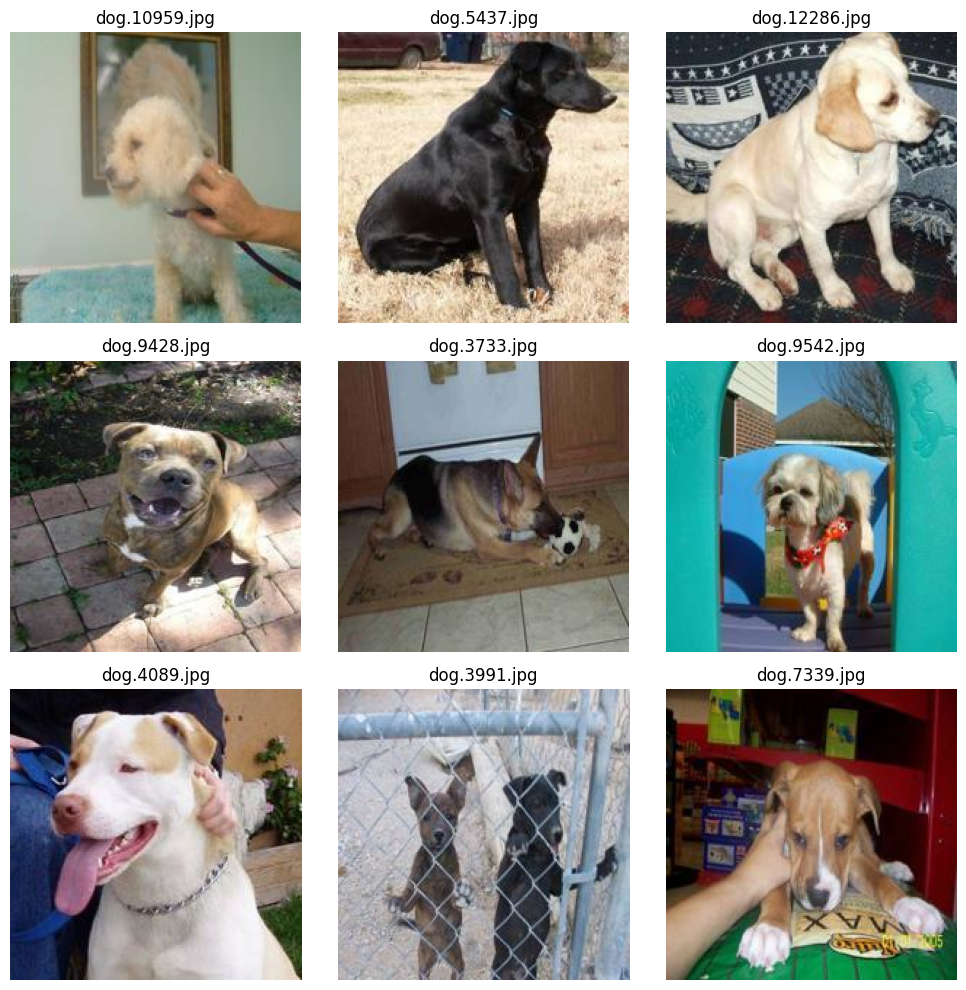

In [6]:
from PIL import Image

dog_images = [file for file in files if file.startswith('dog')] #filtro solo los perros

dog_images = dog_images[:9]

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    img_path = os.path.join('../train', dog_images[i])  # Ruta completa de la imagen
    img = Image.open(img_path)  # Cargar la imagen
    ax.imshow(img)  # Mostrar imagen
    ax.axis("off")  # Ocultar ejes
    ax.set_title(dog_images[i])  # Mostrar el nombre del archivo

plt.tight_layout()  # Ajustar el diseño
plt.show() 

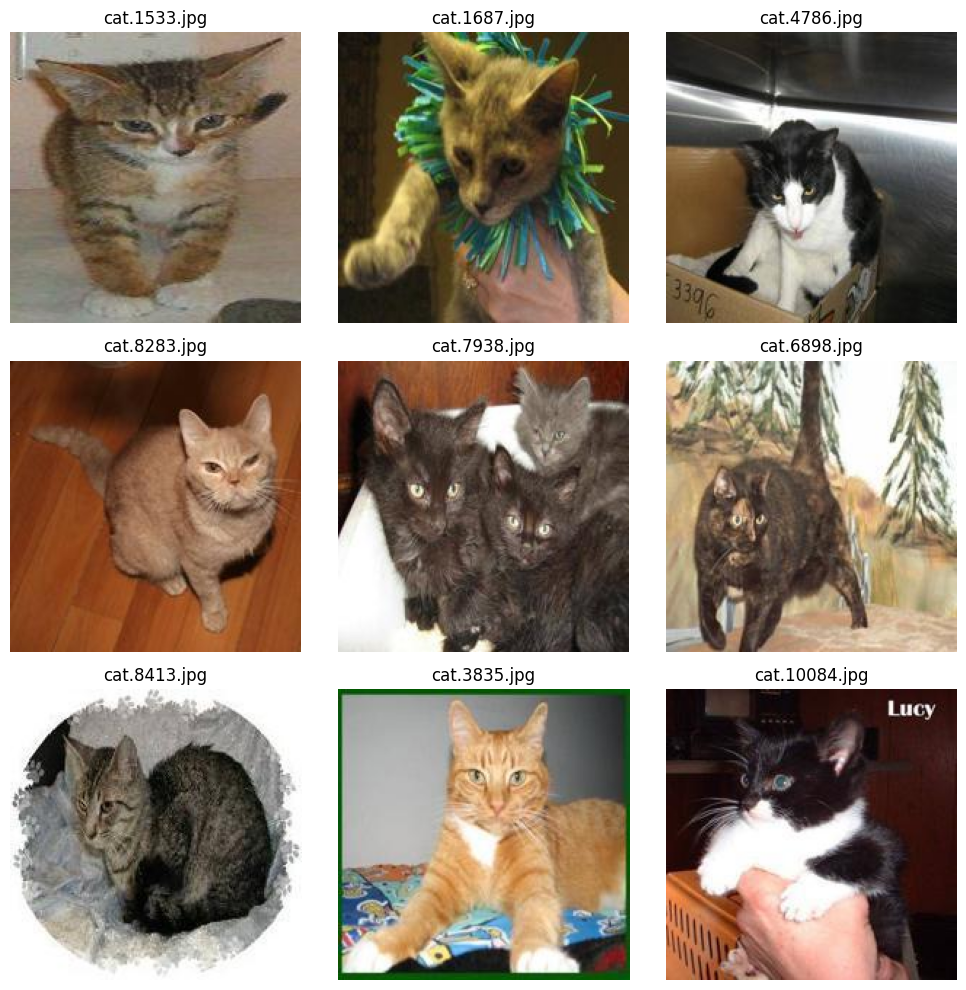

In [7]:
cat_images = [file for file in files if file.startswith('cat')] #filtro solo los perros

cat_images = cat_images[:9]

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    img_path = os.path.join('../train', cat_images[i])  # Ruta completa de la imagen
    img = Image.open(img_path)  # Cargar la imagen
    ax.imshow(img)  # Mostrar imagen
    ax.axis("off")  # Ocultar ejes
    ax.set_title(cat_images[i])  # Mostrar el nombre del archivo

plt.tight_layout()  # Ajustar el diseño
plt.show() 

Dado que tienen distintos tamaños vamos a redimensionar primero

In [8]:
# Este código ya ha sido ejecutado por lo que dará error si se ejecuta de nuevo
'''folders = ["../train", "../test1"]

target_size = (200, 200)

for folder in folders:
    filenames = os.listdir(folder)
    
    for filename in filenames:
        img_path = os.path.join(folder, filename)  # Ruta original
        
        try:
            img = Image.open(img_path).resize(target_size)
            img.save(img_path)
        
        except Exception as e:
            print(f"Error procesando {filename}: {e}")'''

'folders = ["../train", "../test1"]\n\ntarget_size = (200, 200)\n\nfor folder in folders:\n    filenames = os.listdir(folder)\n\n    for filename in filenames:\n        img_path = os.path.join(folder, filename)  # Ruta original\n\n        try:\n            img = Image.open(img_path).resize(target_size)\n            img.save(img_path)\n\n        except Exception as e:\n            print(f"Error procesando {filename}: {e}")'

Se crea el generador de imágenes

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,     
    shear_range=0.1,     
    zoom_range=0.2,      
    horizontal_flip=True 
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
trdata = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../train",
    x_col="filename", 
    y_col="category",  
    target_size=(200, 200),
    batch_size=32,
    class_mode="categorical"
)

val_gen = test_datagen.flow_from_dataframe(
    dataframe=validate_df,
    directory="../train",
    x_col="filename",
    y_col="category",
    target_size=(200, 200),
    batch_size=32,
    class_mode="categorical"
)

tsdata = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory="../test1",
    x_col="filename",
    y_col=None,
    target_size=(200, 200),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


Definimos la arquitectura del modelo:

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200,200,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/home/vscode/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-25 18:31:08.013612: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Debido al tiempo que tarda el modelo en entrenarse que eso está dando muchos problemas al trabajar dentro de github he recurrido a una estructura mucho más simple.

# Entrenamiento del modelo

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

FAST_RUN = True  #Esto es para realizar un entrenamiento rápido, cambiar a False para realizar un entrenamiento completo
epochs = 3 if FAST_RUN else 50 

checkpoint = ModelCheckpoint(
    'model.keras',             
    monitor='val_loss',     # dado que no se indicaba ninguna, usaré esta métrica para monitorear
    verbose=1,              
    save_best_only=True,    
    mode='min'              
)

earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    trdata,  
    steps_per_epoch=trdata.samples // trdata.batch_size,
    validation_data=val_gen,  
    validation_steps=val_gen.samples // val_gen.batch_size,
    epochs=epochs,
    callbacks=[checkpoint, earlystop]
)

/home/vscode/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
 18/625 ━━━━━━━━━━━━━━━━━━━━ 12:33 1s/step - accuracy: 0.4824 - loss: 4.7300

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.5416 - loss: 1.0060
Epoch 1: val_loss improved from inf to 0.62914, saving model to model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 529s 835ms/step - accuracy: 0.5416 - loss: 1.0056 - val_accuracy: 0.6488 - val_loss: 0.6291
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.6519 - loss: 0.6339
Epoch 2: val_loss improved from 0.62914 to 0.57186, saving model to model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 562s 844ms/step - accuracy: 0.6520 - loss: 0.6339 - val_accuracy: 0.7025 - val_loss: 0.5719
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accuracy: 0.6967 - loss: 0.5792
Epoch 3: val_loss improved from 0.57186 to 0.51598, saving model to model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 502s 804ms/step - accuracy: 0.6967 - loss: 0.5792 - val_accuracy: 0.7488 - val_loss: 0.5160


391/391 ━━━━━━━━━━━━━━━━━━━━ 60s 154ms/step


<Axes: xlabel='predicted_category'>

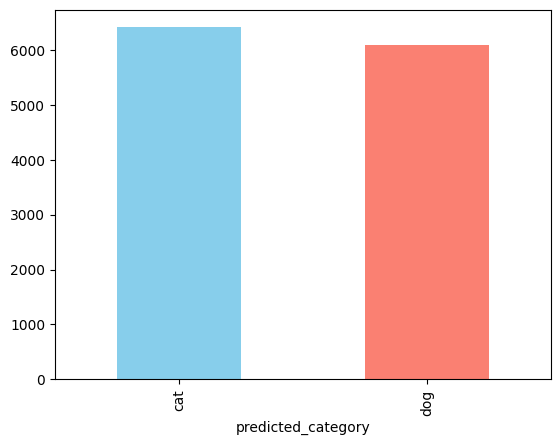

In [17]:
predictions = best_model.predict(tsdata, steps=tsdata.samples // tsdata.batch_size + 1)

# Convertir las predicciones (probabilidades) a índices de clase
predicted_classes = np.argmax(predictions, axis=1)

# Mapear los índices a etiquetas
class_labels = {0: "cat", 1: "dog"}
predicted_labels = [class_labels[i] for i in predicted_classes]

test_df = pd.DataFrame({'predicted_category': predicted_labels})

# Contamos las instancias de cada categoría
test_df['predicted_category'].value_counts().plot.bar(color=['skyblue', 'salmon'])